In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from state_evolution.data_models.custom import Custom
from state_evolution.experiments.learning_curve import CustomExperiment

# Replicas vs Simulations: logistic loss

In this notebook we will check replicas match simulation for the simplest example of a complex teacher: the single-layer hidden manifold model
$$
z = \rm{sign}\left(\frac{1}{\sqrt{d}}\bar{\rm{F}}c\right), \qquad x = \rm{erf}\left(\frac{1}{\sqrt{d}}\rm{F}c\right), \qquad c\sim\mathcal{N}(0,\rm{I}_{d})
$$

In this case, recall that the covariances can be computed analytically, and are given by:

 \begin{align}
 \Psi = \bar{\kappa}_{1}^2 \bar{\rm{F}}\bar{\rm{F}}^{\top}+\bar{\kappa}_{\star}^2\rm{I}_{k}, && \Phi = \bar{\kappa}_{1}\kappa_{1} \rm{F}\bar{\rm{F}}^{\top}, && \Omega = \kappa_{1}^2 \rm{F}\rm{F}^{\top}+\kappa_{\star}^2\rm{I}_{p}
 \end{align}
 
with $\kappa_{1} \equiv \mathbb{E}\left[\xi\sigma(\xi)\right]$ and $\kappa_{\star}^2 \equiv \mathbb{E}\left[\sigma(\xi)\right]^2-\kappa_{1}^2$ for $\xi\sim\mathcal{N}(0,1)$ (idem for the bar). 

## Global variables

In [6]:
COEFICIENTS = {'relu': (1/np.sqrt(2*np.pi), 0.5, np.sqrt((np.pi-2)/(4*np.pi))), 
               'erf': (0, 2/np.sqrt(3*np.pi), 0.200364), 'tanh': (0, 0.605706, 0.165576),
               'sign': (0, np.sqrt(2/np.pi), np.sqrt(1-2/np.pi))}

In [7]:
lamb = 0.01

d = 1000 # dimension of c
p = 2000 # dimension of x
k = 1000 # dimension of k

F_teacher = np.random.normal(0,1, (d,k)) / np.sqrt(d) # teacher projection
F_student = np.random.normal(0,1, (d,p)) / np.sqrt(d) # student proojection

# Coefficients
_, kappa1_teacher, kappastar_teacher = COEFICIENTS['sign']
_, kappa1_student, kappastar_student = COEFICIENTS['erf']

# Covariances
Psi = (kappa1_teacher**2 * F_teacher.T @ F_teacher + kappastar_teacher**2 * np.identity(k))
Omega = (kappa1_student**2 * F_student.T @ F_student + kappastar_student**2 * np.identity(p))
Phi = kappa1_teacher * kappa1_student * F_student.T @ F_teacher

## Replicas

Load data model

In [4]:
data_model = Custom(teacher_teacher_cov = Psi, 
                    student_student_cov = Omega, 
                    teacher_student_cov = Phi)

Load experiment

In [9]:
experiment = CustomExperiment(task = 'logistic_regression', 
                              regularisation = 0.01, 
                              data_model = data_model, 
                              initialisation='uninformed', 
                              tolerance = 1e-7, 
                              damping = 0.5, 
                              verbose = True, 
                              max_steps = 1000)

Run experiiment for a range of sample complexities

In [10]:
alphas = np.linspace(0.01, 3, 50)
experiment.learning_curve(alphas = alphas)

Runninig sample complexity: 0.01
t: 0, diff: 476.80025585936, self overlaps: 0.0012964536668311822, teacher-student overlap: 0.001627414127217054
t: 1, diff: 238.42354381192078, self overlaps: 0.0029813073107644627, teacher-student overlap: 0.0027438599330154574
t: 2, diff: 119.25281590506688, self overlaps: 0.007749464930991353, teacher-student overlap: 0.004534813116330104
t: 3, diff: 59.69125765054079, self overlaps: 0.018627150079972024, teacher-student overlap: 0.007126793878577357
t: 4, diff: 29.93274947864762, self overlaps: 0.038627029287573854, teacher-student overlap: 0.010419208286552793
t: 5, diff: 15.06100498546059, self overlaps: 0.06745795896898653, teacher-student overlap: 0.01400233815633237
t: 6, diff: 7.612463389261026, self overlaps: 0.10019369951805754, teacher-student overlap: 0.017336181579201238
t: 7, diff: 3.8646067080736723, self overlaps: 0.1306139455305911, teacher-student overlap: 0.020043101101674073
t: 8, diff: 1.9684199371519016, self overlaps: 0.1549379

Saving replica data

In [30]:
experiment.save_experiment(directory='./data/replicas', 
                           name='replicas_logistic_teacher=sign_student=erf_lamb={}'.format(lamb))

Saving experiment at ./data/replicas/replicas_logistic_teacher=sign_student=erf_lamb=0.01.csv


In [12]:
replicas = experiment.get_curve()

## Simulation

In [21]:
from scipy.special import erf
from sklearn.linear_model import LogisticRegression

Now let's simulate the problem above.

In [22]:
# Generate an instance of the data
def generate_samples(sample_complexity, model='get'):
    n = int(p*sample_complexity)
    C = np.random.normal(0,1, (n,d))
    
    if model == 'get':
        Z = kappa1_teacher * C @ F_teacher + kappastar_teacher * np.random.normal(0,1, (n,k))
        X = kappa1_student * C @ F_student + kappastar_student * np.random.normal(0,1, (n,p))
    
    elif model == 'nl':
        Z = np.sign(C @ F_teacher)
        X = erf(C @ F_student)     
    
    return Z, X

def get_instance(sample_complexity, signal, model='get'):
    Z, X = generate_samples(sample_complexity, model=model)
    
    y = np.sign((Z @ signal)/np.sqrt(k))
    
    return y, X

def generate_instance(sample_complexity, model='get'):
    signal = np.random.normal(0,1, k)
    
    y, X = get_instance(sample_complexity, signal, model=model)
    
    return signal, y, X

In [23]:
# Simulate the problem for a given sample complexity and average over given number of seeds.
def simulate(sample_complexity, lamb, seeds=1, model='get'):
    eg, et, m, q = [], [], [], []
    
    for i in range(seeds):
        print('Running seed={}'.format(i))
        
        theta0, y, X = generate_instance(sample_complexity, model=model)
        n = X.shape[0]
        #Compute the optimal weight

        w = LogisticRegression(penalty='l2',solver='lbfgs',fit_intercept=False, 
                               C = lamb**(-1), max_iter=1e4, tol=1e-7, verbose=0).fit(X/np.sqrt(p),y).coef_[0] 
            
        yhat = np.sign(X @ w/np.sqrt(p))

        train_error = 0.25 * np.mean((yhat - y)**2)

        ynew, Xnew = get_instance(sample_complexity, theta0, model=model)

        yhatnew = np.sign((Xnew @ w)/np.sqrt(p))

        test_error = 0.25 * np.mean((yhatnew - ynew)**2)

        teacher_student = w.T @ Phi @ theta0 / np.sqrt(k*p)
        student_student = w.T @ Omega @ w /p

        eg.append(test_error)
        et.append(train_error)
        
        m.append(teacher_student)
        q.append(student_student)


        
    return (np.mean(et), np.mean(eg), np.mean(q), np.mean(m), 
            np.std(et), np.std(eg), np.std(q), np.std(m))

In [24]:
# Iterate over sample complexities
alphas = [0.25, 0.5, 0.75, 1, 1.5, 2,  2.5]
simulation = {'model': [], 'dimension': [], 'sample_complexity': [], 'train_error': [], 
              'test_error': [], 'lambda': [], 'seeds': [], 'std_et': [], 'std_eg': [], 
              'm': [], 'm_std': [], 'q': [], 'q_std': []}
seeds = 10

for alpha in alphas:
    print('Sample complexity: {}'.format(alpha))
    train_error, test_error, q, m, std_et, std_eg, q_std, m_std  = simulate(alpha, lamb, seeds=seeds, model='nl')

    simulation['model'].append('hmm_teacher')

    simulation['sample_complexity'].append(alpha)

    simulation['std_et'].append(std_et)
    simulation['std_eg'].append(std_eg)

    simulation['test_error'].append(test_error)
    simulation['train_error'].append(train_error)

    simulation['m'].append(m)
    simulation['q'].append(q)
    simulation['m_std'].append(m_std)
    simulation['q_std'].append(q_std)

    simulation['lambda'].append(lamb)
    simulation['seeds'].append(seeds)

    simulation['dimension'].append(d)

simulation = pd.DataFrame.from_dict(simulation)

Sample complexity: 0.25
Running seed=0
Running seed=1
Running seed=2
Running seed=3
Running seed=4
Running seed=5
Running seed=6
Running seed=7
Running seed=8
Running seed=9
Sample complexity: 0.5
Running seed=0
Running seed=1
Running seed=2
Running seed=3
Running seed=4
Running seed=5
Running seed=6
Running seed=7
Running seed=8
Running seed=9
Sample complexity: 0.75
Running seed=0
Running seed=1
Running seed=2
Running seed=3
Running seed=4
Running seed=5
Running seed=6
Running seed=7
Running seed=8
Running seed=9
Sample complexity: 1
Running seed=0
Running seed=1
Running seed=2
Running seed=3
Running seed=4
Running seed=5
Running seed=6
Running seed=7
Running seed=8
Running seed=9
Sample complexity: 1.5
Running seed=0
Running seed=1
Running seed=2
Running seed=3
Running seed=4
Running seed=5
Running seed=6
Running seed=7
Running seed=8
Running seed=9
Sample complexity: 2
Running seed=0
Running seed=1
Running seed=2
Running seed=3
Running seed=4
Running seed=5
Running seed=6
Running s

Saving simulation data

In [32]:
#simulation.to_csv('./data/simulations/simulations_logistic_teacher=sign_student=erf_lamb={}.csv'.format(lamb))

## Comparison plots

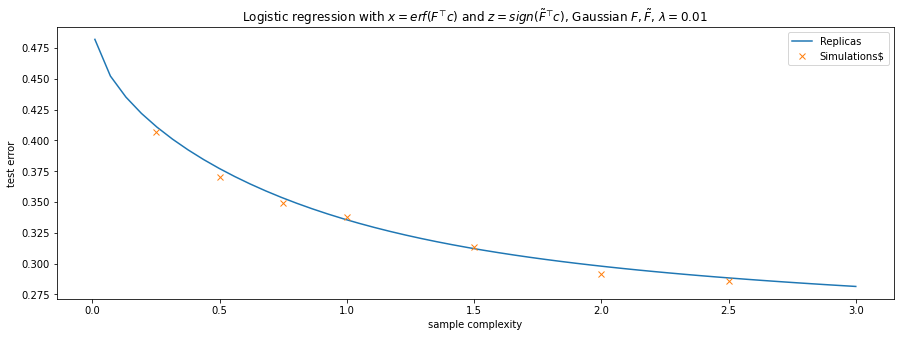

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
#plt.xlim((2,10e6))
plt.title(r"Logistic regression with $x = erf(F^\top c)$ and $z = sign(\tilde{F}^\top c)$, Gaussian $F, \tilde{F}$, $\lambda=0.01$")
#plt.ylim((0,2))

replicas.plot(x='sample_complexity', y='test_error', style='-', ax=ax, label='Replicas')
simulation.plot(x='sample_complexity', y='test_error', style='x', ax=ax, label='Simulations$')

plt.ylabel(r"test error")
plt.xlabel(r"sample complexity")

plt.legend()
#plt.savefig('../figs/ridge_teacher=sign_student=erf_lambda=0.1.pdf', bbox_inches='tight')